In [6]:
#Added this part of code to split the dataset
! pip install split-folders
import splitfolders
input_folder = "animaldst\input"
output = "animaldst\output"
 # ratio of split are in order of train/val/test.
splitfolders.ratio(input_folder, output=output, seed=42, ratio=(.8, .1, .1))

In [7]:
import pandas as pd
import numpy as np 
import itertools
import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix 
from keras.models import Sequential 
from keras import optimizers
from keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from keras.layers import Dropout, Flatten, Dense 
from keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time

In [12]:
#dimension of the image
img_wid, img_ht = 224, 224 
 
#creating bottleneckfile
bottleneck_path = 'bottleneck_fc_model.h5'
#datasets
train_dir = 'animaldst/output/train'
validation_dir = 'animaldst/output/val' 
test_dir = 'animaldst/output/test'
 
# number of epochs to train model 
epochs = 7  
batch_size = 50 #batch size

In [13]:
#code for vgc16 model
vgg16 = applications.VGG16(include_top=False, weights='imagenet')
datagen = ImageDataGenerator(rescale=1. / 255) 

In [14]:
# run once for training data
start_time = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    train_dir, 
    target_size=(img_wid, img_ht), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_training_samples = len(generator.filenames) 
num_of_class = len(generator.class_indices) 
 
predict_size_of_train = int(math.ceil(nb_training_samples / batch_size)) 
 
bottleneck_feature_train = vgg16.predict_generator(generator, predict_size_of_train) 
 
np.save('bottleneck_feature_train.npy', bottleneck_feature_train)
end_time= datetime.datetime.now()
elapsed_time= end_time-start_time
print ('Time:', elapsed_time)

Found 20938 images belonging to 10 classes.


C:\Users\DHANASHREE\AppData\Local\Temp\ipykernel_9172\2221854724.py:16: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  bottleneck_feature_train = vgg16.predict_generator(generator, predict_size_of_train)


Time: 1:14:32.498759


In [15]:
# run once for validation data
start_time = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    validation_dir, 
    target_size=(img_wid, img_ht), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_valid_samples = len(generator.filenames) 
num_of_class = len(generator.class_indices) 
 
predict_size_of_valid = int(math.ceil(nb_valid_samples / batch_size)) 
 
bottleneck_feature_valid = vgg16.predict(generator, predict_size_of_valid) 
 
np.save('bottleneck_feature_valid.npy', bottleneck_feature_valid)
end_time= datetime.datetime.now()
elapsed_time= end_time-start_time
print ('Time:', elapsed_time)

Found 2614 images belonging to 10 classes.
53/53 [==============================] - 664s 12s/step
Time: 0:11:06.402868


In [16]:
# run once for testing data
start_time = datetime.datetime.now()
 
generator = datagen.flow_from_directory( 
    test_dir, 
    target_size=(img_wid, img_ht), 
    batch_size=batch_size, 
    class_mode=None, 
    shuffle=False) 
 
nb_test_samples = len(generator.filenames) 
num_of_class = len(generator.class_indices) 
 
predict_size_of_test = int(math.ceil(nb_test_samples / batch_size)) 
 
bottleneck_feature_test = vgg16.predict(generator, predict_size_of_test) 
 
np.save('bottleneck_feature_test.npy', bottleneck_feature_test)
end_time= datetime.datetime.now()
elapsed_time= end_time-start_time
print ('Time:', elapsed_time)

Found 2627 images belonging to 10 classes.
53/53 [==============================] - 580s 11s/step
Time: 0:09:41.402467


In [18]:
#training data
generator_top = datagen.flow_from_directory( 
   train_dir, 
   target_size=(img_wid, img_ht), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_training_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
training_data = np.load('bottleneck_feature_train.npy') 
 
training_labels = generator_top.classes 
 
training_labels = to_categorical(training_labels, num_classes=num_classes)

Found 20938 images belonging to 10 classes.


In [19]:
#validation data
generator_top = datagen.flow_from_directory( 
   validation_dir, 
   target_size=(img_wid, img_ht), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_valid_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
validation_data = np.load('bottleneck_feature_valid.npy') 
 
validation_labels = generator_top.classes 
 
validation_labels = to_categorical(validation_labels, num_classes=num_classes)

Found 2614 images belonging to 10 classes.


In [21]:
#testing data
generator_top = datagen.flow_from_directory( 
   test_dir, 
   target_size=(img_wid, img_ht), 
   batch_size=batch_size, 
   class_mode='categorical', 
   shuffle=False) 
 
nb_test_samples = len(generator_top.filenames) 
num_classes = len(generator_top.class_indices) 
 
test_data = np.load('bottleneck_feature_test.npy') 
 
test_labels = generator_top.classes 
 
test_labels = to_categorical(test_labels, num_classes=num_classes)

Found 2627 images belonging to 10 classes.


In [45]:
start_time = datetime.datetime.now()
model = Sequential() 
model.add(Flatten(input_shape=training_data.shape[1:])) 
model.add(Dense(100, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.5)) 
model.add(Dense(50, activation=keras.layers.LeakyReLU(alpha=0.3))) 
model.add(Dropout(0.3)) 
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss='categorical_crossentropy',
   optimizer=optimizers.RMSprop(learning_rate=1e-4),
   metrics=['acc'])
history = model.fit(training_data, training_labels, 
   epochs=10,
   batch_size=batch_size, 
   validation_data=(validation_data, validation_labels))
model.save_weights(bottleneck_path)
(eval_loss, eval_accuracy) = model.evaluate( 
    validation_data, validation_labels, batch_size=batch_size,     verbose=1)
print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
print("[INFO] Loss: {}".format(eval_loss)) 
end_time= datetime.datetime.now()
elapsed_time= end_time-start_time
print ('Time:' , elapsed_time)

Epoch 1/10
419/419 [==============================] - 36s 81ms/step - loss: 1.2148 - acc: 0.5960 - val_loss: 0.7286 - val_acc: 0.7865
Epoch 2/10
419/419 [==============================] - 28s 66ms/step - loss: 0.7765 - acc: 0.7428 - val_loss: 0.6230 - val_acc: 0.7953
Epoch 3/10
419/419 [==============================] - 25s 59ms/step - loss: 0.6317 - acc: 0.7957 - val_loss: 0.5201 - val_acc: 0.8317
Epoch 4/10
419/419 [==============================] - 23s 54ms/step - loss: 0.5411 - acc: 0.8263 - val_loss: 0.4723 - val_acc: 0.8454
Epoch 5/10
419/419 [==============================] - 25s 60ms/step - loss: 0.4847 - acc: 0.8429 - val_loss: 0.4922 - val_acc: 0.8344
Epoch 6/10
419/419 [==============================] - 24s 57ms/step - loss: 0.4318 - acc: 0.8602 - val_loss: 0.4849 - val_acc: 0.8412
Epoch 7/10
419/419 [==============================] - 26s 62ms/step - loss: 0.3872 - acc: 0.8727 - val_loss: 0.4064 - val_acc: 0.8688
Epoch 8/10
419/419 [==============================] - 41s 99ms

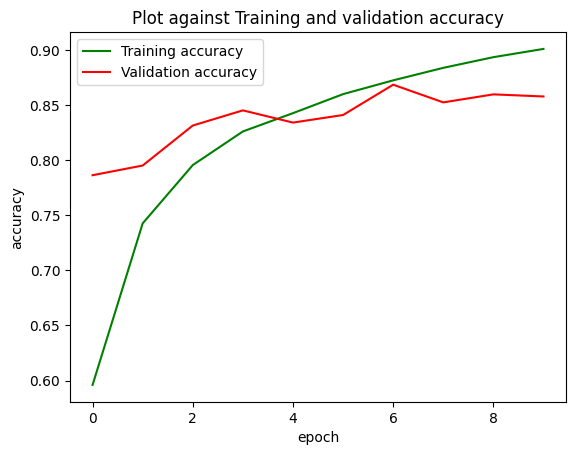

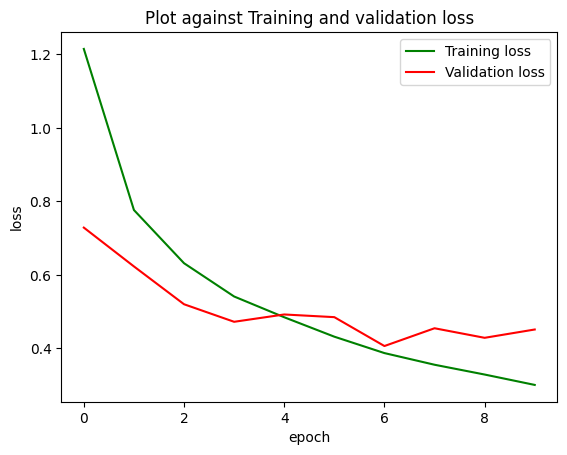

In [46]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Plot against Training and validation accuracy')
plt.ylabel('accuracy') 
plt.xlabel('epoch')
plt.legend()
plt.figure()
plt.plot(epochs, loss, 'g', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Plot against Training and validation loss')
plt.ylabel('loss') 
plt.xlabel('epoch')
plt.legend()
plt.show()

In [47]:
model.evaluate(test_data, test_labels)

83/83 [==============================] - 2s 18ms/step - loss: 0.4417 - acc: 0.8592


[0.44174256920814514, 0.8591549396514893]

In [48]:
preds = np.round(model.predict(test_data), 0)
print('Result ', preds)


83/83 [==============================] - 1s 10ms/step
Result  [[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 1.]]


In [42]:
animals = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'ragno', 'sheep', 'squirrel']
class_metrics = metrics.classification_report(test_labels, preds, target_names=animals)
print(class_metrics)

              precision    recall  f1-score   support

   butterfly       0.96      0.90      0.93       212
         cat       0.92      0.75      0.83       168
     chicken       0.94      0.88      0.91       311
         cow       0.93      0.60      0.72       188
         dog       0.83      0.87      0.85       487
    elephant       0.85      0.92      0.88       146
       horse       0.93      0.78      0.85       263
       ragno       0.96      0.94      0.95       483
       sheep       0.81      0.71      0.76       182
    squirrel       0.89      0.80      0.84       187

   micro avg       0.90      0.84      0.87      2627
   macro avg       0.90      0.81      0.85      2627
weighted avg       0.90      0.84      0.87      2627
 samples avg       0.84      0.84      0.84      2627



C:\Users\DHANASHREE\anaconda3\envs\my-env\lib\site-packages\sklearn\metrics\_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [83]:

#To get better visual of the confusion matrix:
def plot_nn_confusion_matrix(cm, classes,
   normalize=False,
   title='Confusion matrix',
   cmap=plt.cm.BuPu):
 
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

 
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
 
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")
 
    plt.tight_layout()
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label') 

Normalized confusion matrix


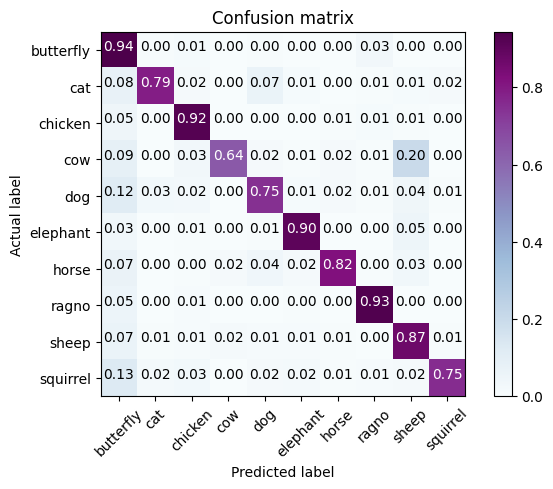

In [84]:
plot_nn_confusion_matrix(confusion_matrix, animals, normalize=True)

[INFO] Reading Image
1/1 [==============================] - 0s 93ms/step
ID: 0, Label: butterfly 0.0%
ID: 1, Label: cat 0.0%
ID: 2, Label: chicken 0.0%
ID: 3, Label: cow 0.06%
ID: 4, Label: dog 0.0%
ID: 5, Label: elephant 0.02%
ID: 6, Label: horse 0.0%
ID: 7, Label: ragno 0.0%
ID: 8, Label: sheep 99.92%
ID: 9, Label: squirrel 0.0%
Final Result:
.
..
...
ID: 8, Label: sheep


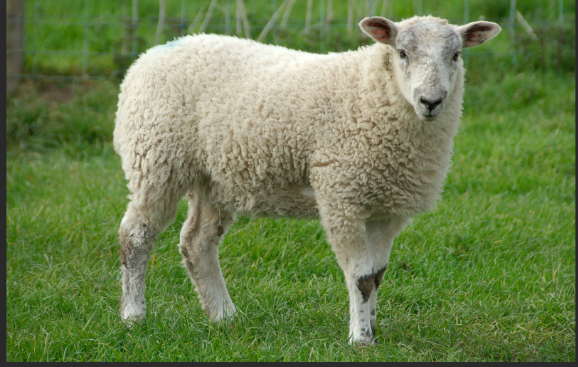

In [44]:
#testing the CNN model using single image input

#function to read image
def read_image_file(fl_path):
   print("[INFO] Reading Image") 
   image = load_img(fl_path, target_size=(224, 224)) 
   image = img_to_array(image) 
   image = np.expand_dims(image, axis=0)
   image /= 255. 
   return image

#function to test a single image
def test_image(path):
  animals = ['butterfly', 'cat', 'chicken', 'cow', 'dog', 'elephant', 'horse', 'ragno', 'sheep', 'squirrel']
  images = read_image_file(path)
  time.sleep(.5)
  bt_prediction = vgg16.predict(images) 
  preds = model.predict(bt_prediction)
  for idx, animal, x in zip(range(0,10), animals , preds[0]):
   print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
  print('Final Result:')
  time.sleep(.5)
  for x in range(3):
   print('.'*(x+1))
   time.sleep(.2)
  #class_predicted = model.predict_classes(bt_prediction)
   class_predicted = np.argmax(preds,axis=1)
  class_dictionary = generator_top.class_indices 
  inv_map = {v: k for k, v in class_dictionary.items()} 
  print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
  return load_img(path)

path = 'animaldst\sheep.PNG'
test_image(path)